**Walk‑Through**
- **STEP 1. Imports** ... Pulls in your helper functions (Fourier term builder, Optuna optimizer, contribution calculator, ROI plotter, etc.).
- **STEP 2. Load Weekly Data** ... Reads the CSV, turns the week column into a DatetimeIndex. Weekly cadence is standard for MMM because media and sales often change weekly.
- **STEP 3. Add Seasonality Features** ... Creates 10 Fourier columns (5 pairs of sine/cosine) to capture 52‑week seasonality. These let linear models fit curved, holiday‑like patterns without over‑fitting.
- **STEP 4. Restrict to Last 5 Years** … Defines data_term = int(52.25 × 5) and slices the most recent ~260 weeks into X (media + features) and y (sales).
- **STEP 5. Quick Visual Check** … Plots y and each column of X to verify data loading, spot outliers, and confirm expected patterns before modeling.
- **STEP 6. Hyper-parameter Search** … Runs run_optimization(regarima_objective, X, y, apply_effects_features, n_trials=20) to let Optuna (or similar) tune ARIMAX lags, decay rates, and transforms over 20 trials.
- **STEP 7. Build Final Model** … Uses create_model_from_trial_regarima(study.best_trial, X, y, apply_effects_features) to fit the chosen configuration on the full training window and produce trained_model, parameters, and predictions.
- **STEP 8. Select Media Drivers** … Sets apply_effects_features = ['traditional','internet','promotional'] so downstream functions know which columns represent paid media spend.
- **STEP 9. Calculate & Plot Contribution** … Calls calculate_and_plot_contribution(y, X, trained_model, (0, max(y)*1.1), apply_effects_features) to compute each channel’s weekly yen contribution and draw a stacked contribution chart.
- **STEP 10. Summarize Contribution Share** … Uses summarize_and_plot_contribution(contribution) to aggregate total contributions and plot each channel’s percentage share of sales.
- **STEP 11. Compute Marketing ROI** … Runs calculate_marketing_roi(X[apply_effects_features], contribution[apply_effects_features]) to get ROI = revenue_contribution ÷ spend for each channel.
- **STEP 12. Contribution × ROI Scatter** … Invokes plot_scatter_of_contribution_and_roi(X[apply_effects_features], contribution[apply_effects_features]) to display a 2-D scatter of spend vs. ROI for quick budget re-allocation insights.

In [1]:
# ────────────────────────────────────────────────────────────────────
# STEP 1. Imports
# ────────────────────────────────────────────────────────────────────
# ☆ NOTE: `mmm_functions.py` is to live in the same repo.
#   It wraps repetitive operations such as Fourier‑term generation,
#   Optuna objective functions, contribution math, and plotting.

from mmm_functions import *


# Matplotlib aesthetics for quick notebook‑style visuals
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 10


In [2]:
# ────────────────────────────────────────────────────────────────────
# STEP 2. Load Weekly Data
# ────────────────────────────────────────────────────────────────────
# Data format assumptions
#   • Index column:  "week"          (Weekly dates, ISO week starts)
#   • Target column: "sales"         (Absolute yen revenue)
#   • Media spend:   "traditional", "internet", "promotional"
#   • Any other columns (price, promo flags, macro indices, etc.)
#     can stay in the CSV and will be used automatically.

dataset = 'df_mmm.csv'
df = pd.read_csv(
    dataset,
    parse_dates=['week'],
    index_col='week',
)
# Quick sanity peek (optional)
print("Head of raw weekly data:")
print(df.head(), "\n")

Head of raw weekly data:
                sales  traditional   internet  promotional
week                                                      
2015-12-27  649315000    656100000          0            0
2016-01-03  958266000            0  178050000    188587500
2016-01-10  755973000            0  150450000    162037500
2016-01-17  551603000            0          0    126900000
2016-01-24  520183000            0  175500000            0 



In [3]:
# ────────────────────────────────────────────────────────────────────
# STEP 3. Add Seasonality Features
# ────────────────────────────────────────────────────────────────────
# Fourier terms allow a *linear* model to capture cyclic patterns.
# • `num=5`  →  5 sine + 5 cosine columns = 10 new features
# • `seasonal=52.25` gives a period of roughly one year in weeks

df = add_fourier_terms(df, num=5, seasonal=52.25)

print("after adding Fourier terms:")
print(df.head())

after adding Fourier terms:
                sales  traditional   internet  promotional  t     sin_1  \
week                                                                      
2015-12-27  649315000    656100000          0            0  0  0.000000   
2016-01-03  958266000            0  178050000    188587500  1  0.119963   
2016-01-10  755973000            0  150450000    162037500  2  0.238193   
2016-01-17  551603000            0          0    126900000  3  0.352983   
2016-01-24  520183000            0  175500000            0  4  0.462674   

               cos_1     sin_2     cos_2     sin_3     cos_3     sin_4  \
week                                                                     
2015-12-27  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
2016-01-03  0.992778  0.238193  0.971218  0.352983  0.935630  0.462674   
2016-01-10  0.971218  0.462674  0.886528  0.660522  0.750806  0.820348   
2016-01-17  0.935630  0.660522  0.750806  0.883026  0.469324  0.991849   
20

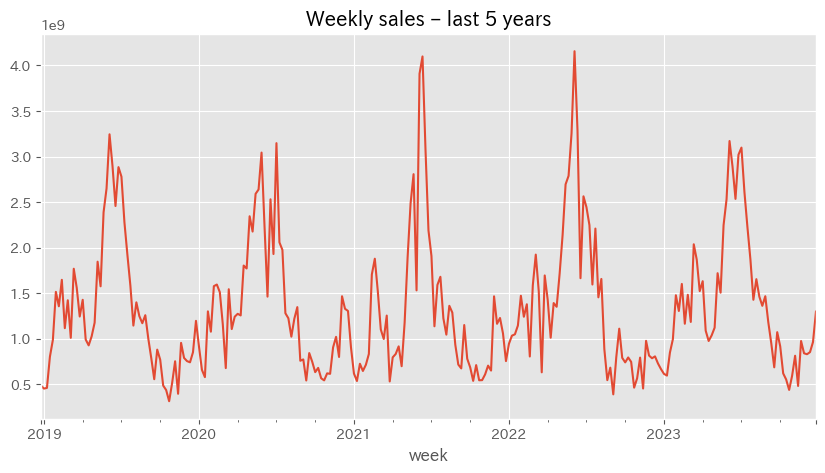

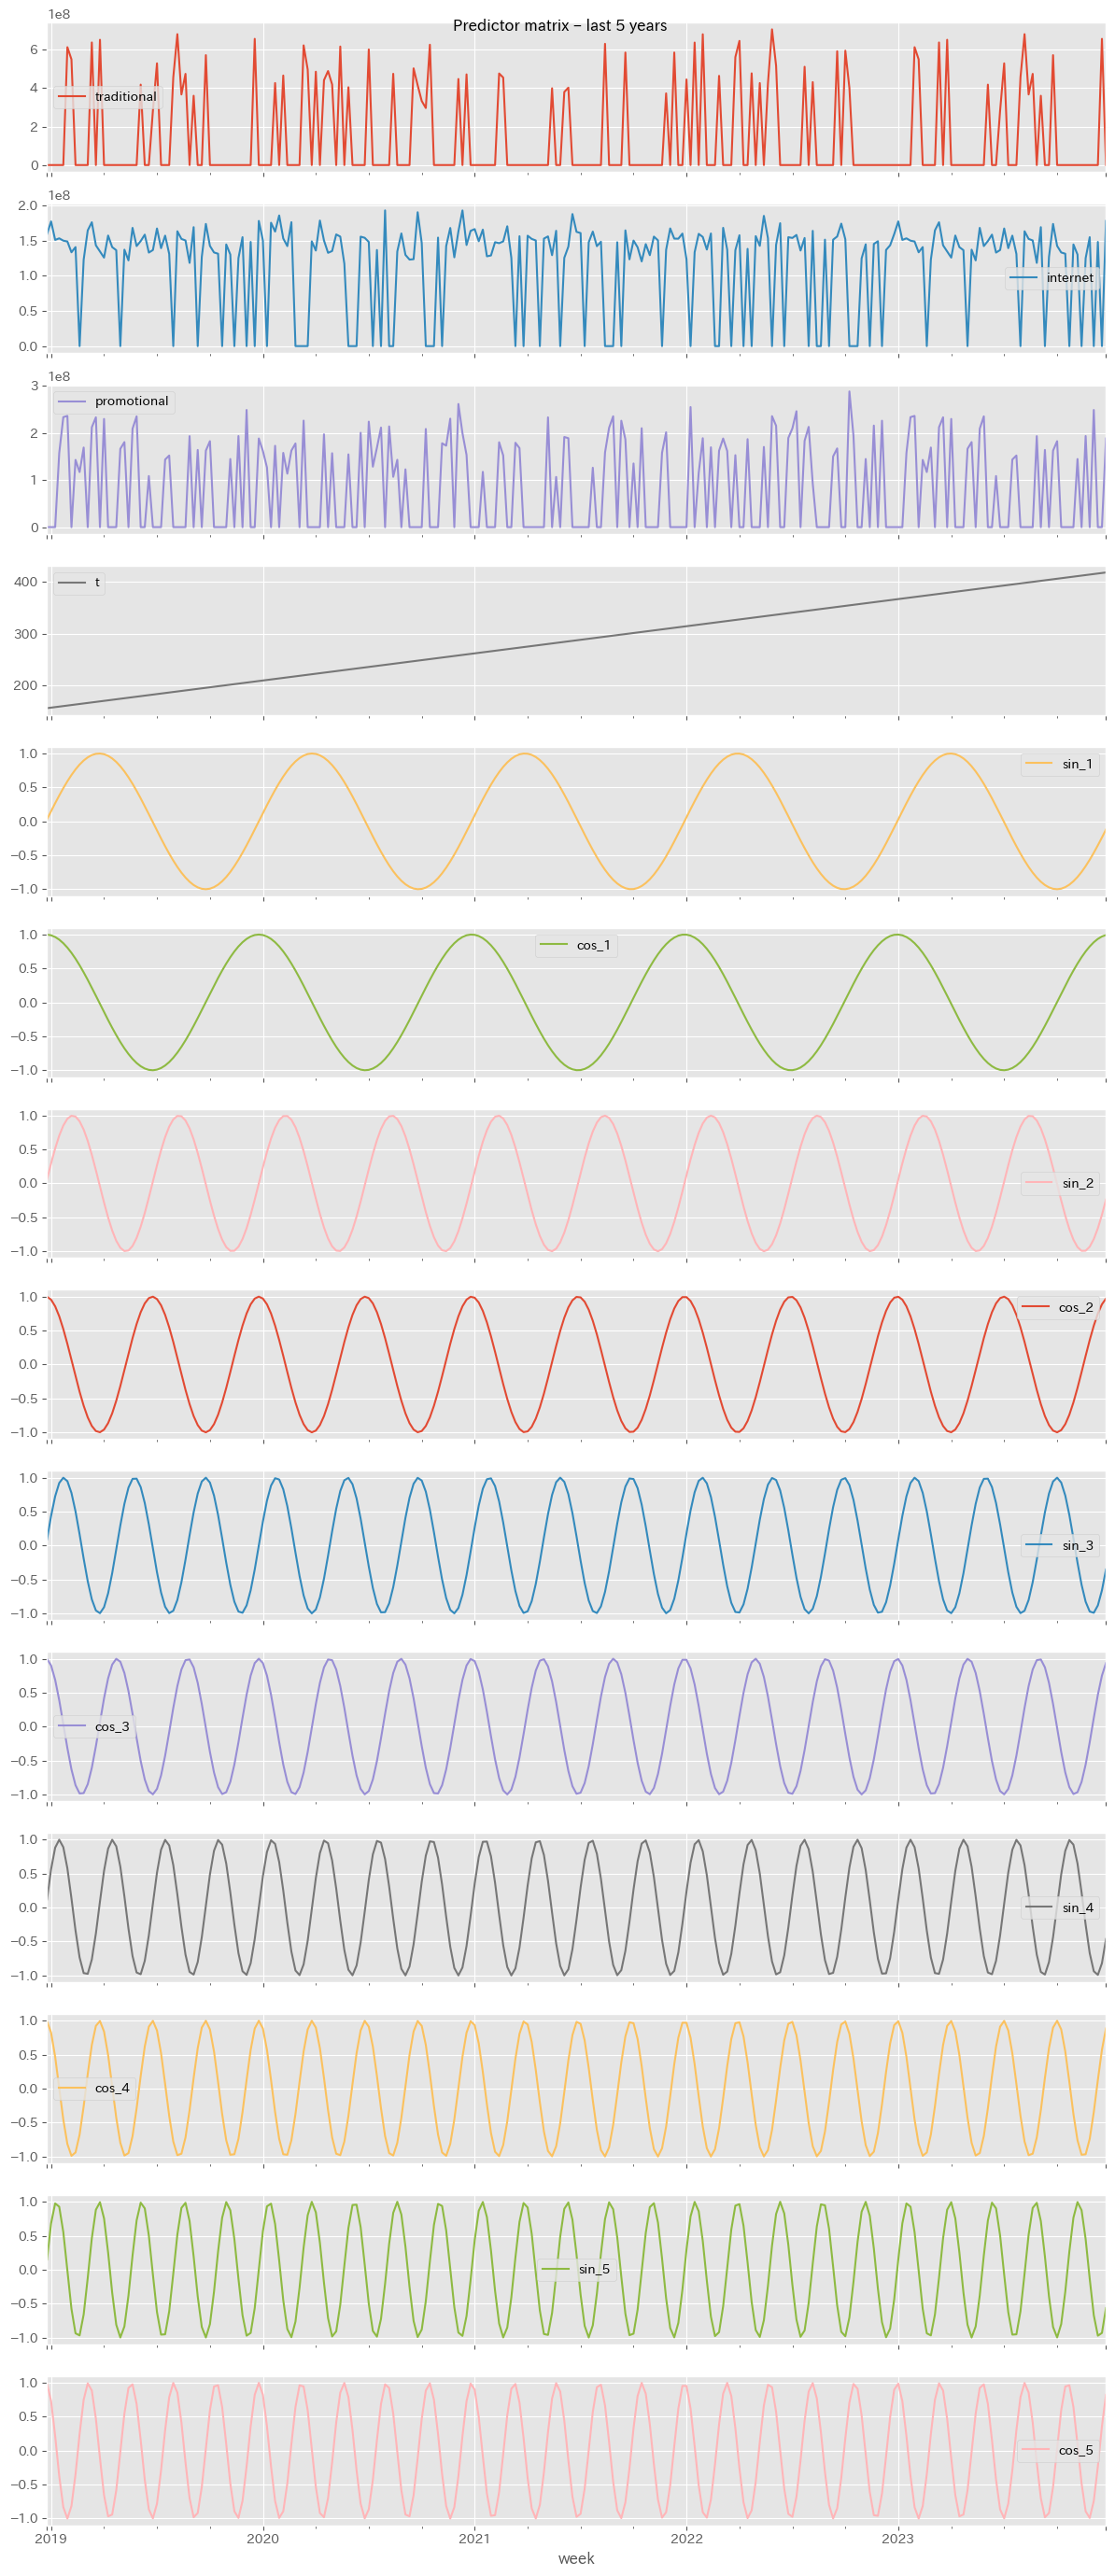

In [4]:
# ────────────────────────────────────────────────────────────────────
# STEP 4. Restrict to the Last 5 Years
# ────────────────────────────────────────────────────────────────────
# Many businesses evolve quickly; focusing on recent history yields
# more relevant elasticities. It also speeds up the Optuna search.
YEARS_BACK   = 5
WEEKS_YEAR   = 52.25
DATA_TERM    = int(YEARS_BACK * WEEKS_YEAR)   # ≈ 260 rows

X = df.drop(columns=["sales"]).iloc[-DATA_TERM:]   # predictors
y = df["sales"].iloc[-DATA_TERM:]                  # target

# Optional: eyeball the data
y.plot(title="Weekly sales – last 5 years")
plt.show()

X.plot(subplots=True, figsize=(12, X.shape[1] * 2),
       title="Predictor matrix – last 5 years")
plt.tight_layout()
plt.show()

In [5]:
# ────────────────────────────────────────────────────────────────────
# STEP 5. Hyper‑parameter Search (Optuna)
# ────────────────────────────────────────────────────────────────────
# `regarima_objective` lives inside mmm_functions.py.
# It typically:
#   • Chooses AR & MA orders, seasonal lags, Box‑Cox/Log transforms,
#   • Selects which Fourier terms or media carry‑over decays to use,
#   • Performs time‑series split validation and returns an error metric.
#
# Reduce `n_trials` when prototyping; raise to 500‑1000 in production.

apply_effects_features=[]

print("Running Optuna search – this may take a few minutes ...")
study = run_optimization(
    regarima_objective, 
    X, y, 
    apply_effects_features, 
#     n_trials=1000
    n_trials=20

)

print("Best trial score:", study.best_value)
print("Best trial params:")
for k, v in study.best_trial.params.items():
    print(f"  • {k}: {v}")
print()


Running Optuna search – this may take a few minutes ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best trial:
Value: 295351373.7527873
Params: 
alpha: 3.165125560374917
Best trial score: 295351373.7527873
Best trial params:
  • alpha: 3.165125560374917



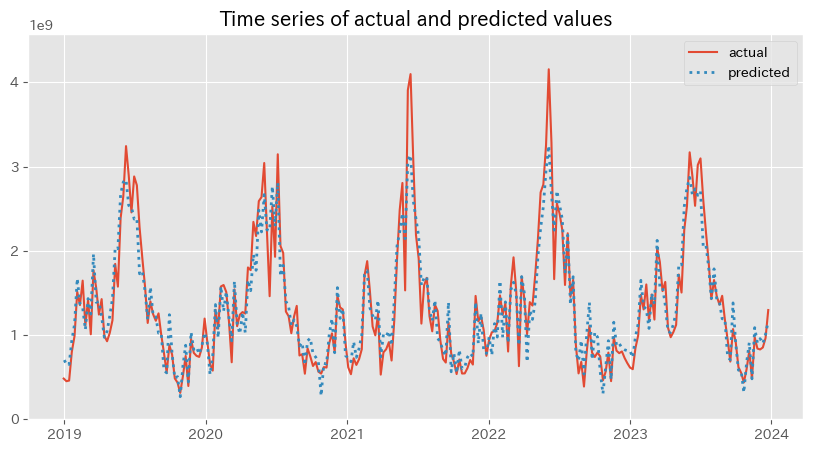

RMSE: 227743925.73217145
MAE: 169879700.99742126
MAPE: 0.13780046069569032
R2: 0.9068121479798816
Final model parameters:
[[], [], 3.165125560374917] 



In [6]:
# ────────────────────────────────────────────────────────────────────
# STEP 6. Train Final Model on Full Window
# ────────────────────────────────────────────────────────────────────


trained_model, model_params, pred = create_model_from_trial_regarima(
    study.best_trial,
    X,
    y,
    apply_effects_features=[],
)

# Inspect the fitted coefficients (optional)
print("Final model parameters:")
print(model_params, "\n")


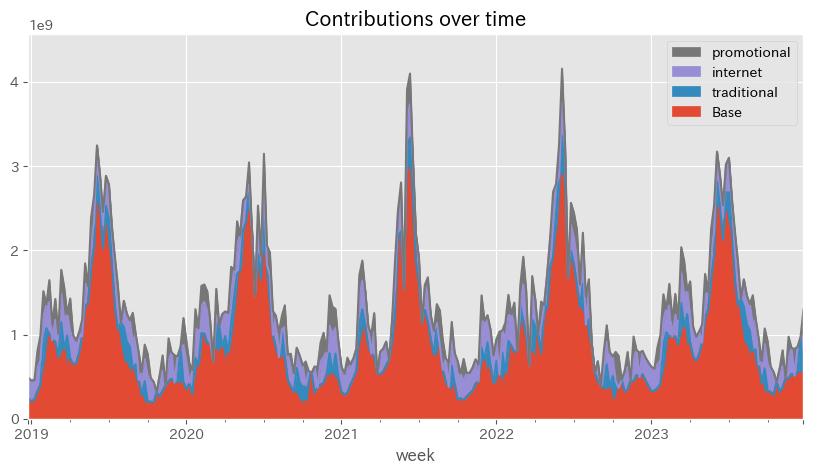

Weekly contribution head:
                    Base  traditional      internet   promotional
week                                                             
2018-12-30  2.411915e+08          0.0  2.423535e+08  0.000000e+00
2019-01-06  2.060153e+08          0.0  2.462367e+08  0.000000e+00
2019-01-13  2.313097e+08          0.0  2.282413e+08  0.000000e+00
2019-01-20  3.226425e+08          0.0  2.810912e+08  1.985373e+08
2019-01-27  4.057749e+08          0.0  2.811122e+08  3.011699e+08 



In [9]:
# ────────────────────────────────────────────────────────────────────
# STEP 7. Define Media Drivers (Paid Channels)
# ────────────────────────────────────────────────────────────────────
# Adjust this list to match the paid‑media columns present in *your*
# data set. These columns will be used for contribution & ROI.
apply_effects_features = ["traditional", "internet", "promotional"]

# ────────────────────────────────────────────────────────────────────
# STEP 8. Calculate & Plot Weekly Contribution
# ────────────────────────────────────────────────────────────────────
# This function multiplies each driver’s weekly spend by its
# elasticity coefficient to yield its **yen contribution**.  
# Contributions for base, trend, and seasonality are calculated too
# (but often hidden in the returned DataFrame if not requested).
contribution = calculate_and_plot_contribution(y, X, trained_model, (0, np.max(y)*1.1), apply_effects_features)


print("Weekly contribution head:")
print(contribution.head(), "\n")

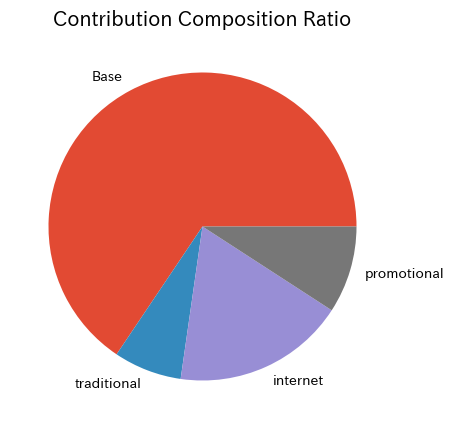

Total contribution (¥) and share (%):
             contribution     ratio
Base         2.292098e+11  0.655806
traditional  2.499600e+10  0.071518
internet     6.329927e+10  0.181109
promotional  3.200327e+10  0.091567


In [10]:
# ────────────────────────────────────────────────────────────────────
# STEP 9. Summarize Contribution Share
# ────────────────────────────────────────────────────────────────────
# Converts weekly yen into totals and visualizes each channel’s
# percentage share of sales for the whole analysis window.


contribution_results = summarize_and_plot_contribution(contribution)

print("Total contribution (¥) and share (%):")
print(contribution_results)


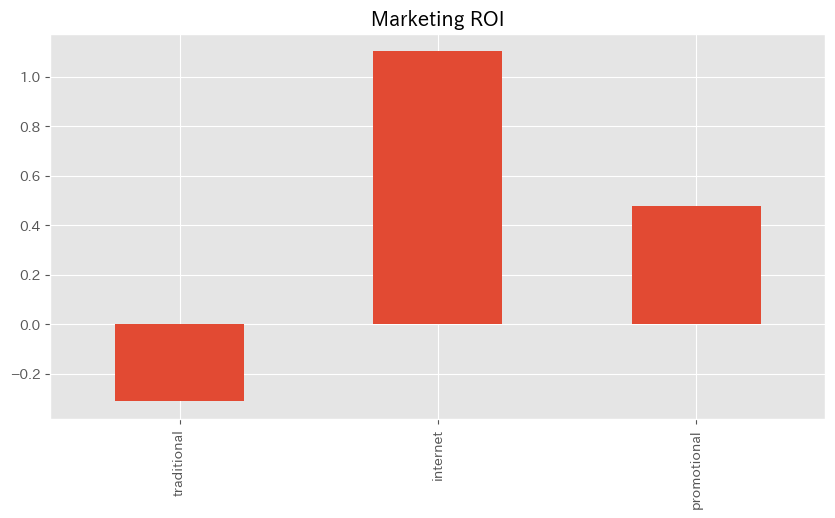

ROI by channel (yen return per yen spent):
traditional   -0.311780
internet       1.103109
promotional    0.477874
dtype: float64


In [11]:
# ────────────────────────────────────────────────────────────────────
# STEP 10. Compute Marketing ROI
# ────────────────────────────────────────────────────────────────────
# ROI formula:  Contribution ÷ Media Spend

ROI = calculate_marketing_roi(
    X[apply_effects_features], 
    contribution[apply_effects_features]
)
print("ROI by channel (yen return per yen spent):")
print(ROI)


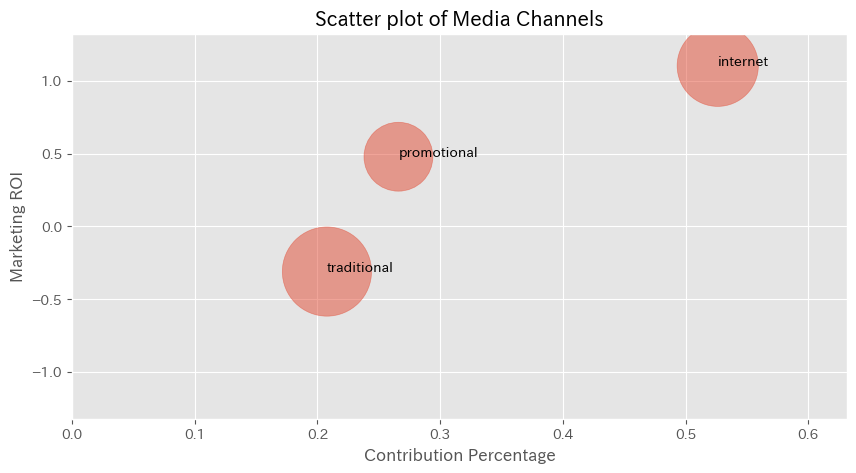

Data used for Contribution × ROI scatter:
             contribution_percentage       ROI         cost
traditional                 0.207783 -0.311780  36319800000
internet                    0.526185  1.103109  30097950000
promotional                 0.266032  0.477874  21654937500


In [12]:
# ────────────────────────────────────────────────────────────────────
# STEP 11. Contribution × ROI Scatter Plot
# ────────────────────────────────────────────────────────────────────
# Quick two‑axis diagnostic:
#   • X‑axis  = total contribution (revenue impact)
#   • Y‑axis  = ROI (efficiency)
# Channels in the *top‑right* quadrant are both big and efficient.


data_to_plot = plot_scatter_of_contribution_and_roi(
    X[apply_effects_features], 
    contribution[apply_effects_features]
)

print("Data used for Contribution × ROI scatter:")
print(data_to_plot)